# Face recognition
**Supervised learning: classification**

**Abstract:** This notebook provides a simple example of a supervised learning problem. We train a classification model to recognize faces of (relatively) known personalities. First, we divide the images into two subsets: one to train the model and another to check how well the model works. We train the model using a more compact version of the images, namely one that retains their essential components, making for faster processing and revealing hidden structures. We fit the model using the training set and define the model's hyper parameters via exhaustive search. Once our model is trained, we use it on the test set to tell the faces in previously unseen images. Lastly, we see how well our model can recognize the personalities in these new images.

The data used in this exaple is an excerpt from the "Labeled Faces in the Wild" dataset provided in the `scikit-learn` package.

**Topics covered:** support vector machine (SVM), cross-validation, dimensionsionality reduction via principal component analysis (PCA), hyper parameter optimization via grid search, eigenfaces.

**Intuition.** Assume you are presented a bunch of mug shots of random people you don't know and you are asked to guess who they are. As you have absolutely no clue, you just guess. Assuming the images you are shown have been randomly selected from a group of 34 people, the odds of getting a blind guess right are 1:33. (Disregarding of course aspects like gender or ethnicity). You are shown image after image and, as math would have it, you fail misserably the test. Discouraged, you proceed to make your way out the door.

But every black cloud has a silver lining. Before you leave the room you are told that next week you will be tested again on the same 34 people. Resolved to do better, as you leave the premisses you start making plans to prepare for next week's rematch.

How do you prepare? A good place to start is to look for as many mug shots of these 34 individuals as you can get your hands on and in the next days study them. Maybe you try to find patterns of how to tell the different faces apart, like the color of their eyes, their hairstyle, the overall shape of their head etc. If you did your study well, you should do miles better in the next test.

Now, let's assume we want to teach a computer to do the same. How do we proceed? Well, exactly the same way! We show the machine images of the different people and tell it: "Look, this is Berlusconi. This is Alberto Toledo...". Once we've shown the machine enough pictures, it should be able to tell us who is who based on a new images.

This is what we will do below.

**Load packages & data.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.svm import SVC # support vector classifier
from sklearn.decomposition import PCA # principal component analysis
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split # cross-validation
from sklearn.model_selection import GridSearchCV # grid search for hyperparameter selection
from sklearn.metrics import confusion_matrix # confusion matrix
import matplotlib.patches as patches
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # accuracy

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw = fetch_lfw_people(min_faces_per_person=30)

**A quick look into the data.** In this example we only keep pictures of the pesonalities for which we have at least 30 different pictures in the dataset. That leaves us with 34 personalities and a total of 2,370 pictures. Each picture is 62x47 pixels, leading to a total size of 2,914 pixels.

In [3]:
n_samples, h, w = lfw.images.shape
print(r'Number of personalities: {}'.format(len(lfw.target_names)))
print(r'Number of images: {}'.format(n_samples))
print(r'Picture dimensions: {}x{} pixels'.format(h, w))
print(r'Total size: {} pixels'.format(h * w))

Number of personalities: 34
Number of images: 2370
Picture dimensions: 62x47 pixels
Total size: 2914 pixels


Here the first five personalities:

In [4]:
for i, p in enumerate(lfw.target_names[:5]):
    print(i, ':', p)

0 : Alejandro Toledo
1 : Alvaro Uribe
2 : Andre Agassi
3 : Ariel Sharon
4 : Arnold Schwarzenegger


Let's look at one example to get a better feel of how an image is stored.

The dataset in `scikit-learn` is stored in a dictionary-like object called *bunch*. A bunch is similar to the DataFrame object in `pandas` and it contains different attributes. We find each image stored in two different formats. Once as a numpy array of 62 rows and 47 columns under the attribute *images*. And once as a row-major "flattened" numpy array of length 2,914 under the attribute *data*. Note for instance that the starting and trailing elements of both arrays are exactly the same. 

In [5]:
np.set_printoptions(precision=3)
print(r'Image stored as a {} numpy array:'.format(lfw.images[1].shape), '\n')
print(lfw.images[1], '\n'*2, '='*50, '\n')
print(r'Image stored as a "flattened" numpy array of length {}:'.format(len(lfw.data[1])), '\n')
print(lfw.data[1])

Image stored as a (62, 47) numpy array: 

[[ 4.667  9.333 16.333 ... 50.667 48.    44.   ]
 [ 8.333 13.    14.    ... 55.667 49.    46.   ]
 [11.    23.333 25.    ... 57.333 48.    41.667]
 ...
 [51.667 55.333 57.667 ... 56.333 57.333 60.333]
 [50.667 54.    56.667 ... 58.333 59.667 61.333]
 [50.    53.    55.667 ... 60.667 61.667 63.333]] 


Image stored as a "flattened" numpy array of length 2914: 

[ 4.667  9.333 16.333 ... 60.667 61.667 63.333]


Each element in the array corresponds to a pixel. The numbers depict the color intensity of the respective pixel. Of course, stearing at a matrix of numbers is a bit hard on the eye. We can view the matrix as an image, though.

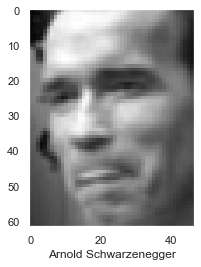

In [6]:
plt.imshow(lfw.images[1], cmap='gray')
plt.xlabel(lfw.target_names[lfw.target[1]])
plt.grid(False)

Let's have a look at the first few images we have in the dataset:

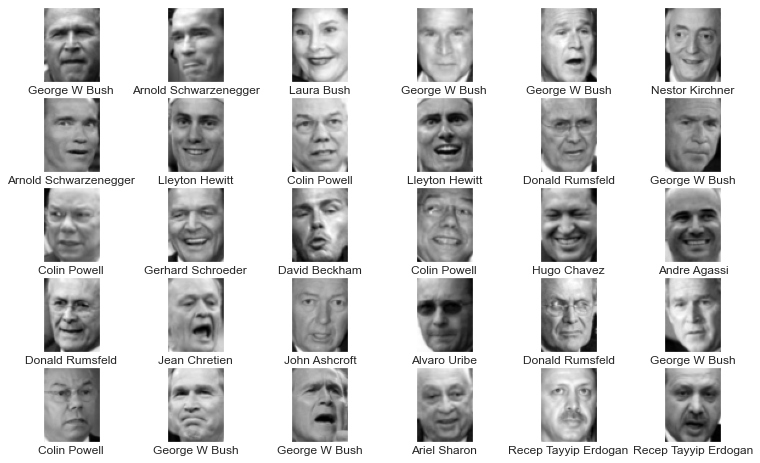

In [7]:
fig, ax = plt.subplots(5, 6, figsize=(13, 8))
for i, a in enumerate(ax.flat):
    a.imshow(lfw.images[i], cmap='gray')
    a.set(xticks=[], yticks=[], xlabel=lfw.target_names[lfw.target[i]])

Nice bunch. :)

Here we can see that all images have been pre-formatted to contain the respective faces within the 62x47 pixel area. That's neat because we don't have to worry about this pre-formatting this time around and we can go straight into training our model.

**Cross-validation.** Next we will split the dataset into two portions, namely a training and a test set. We use the training set to fit our model and then the test set to check how well our model fares. We use 85% of the data for training and 15% for testing. We want to have as much data for training as possible, but also we don't want to be left out with too little data for testing. With the size of this data set, the 85/15 seems to strike the balance.

In [8]:
# Compute features matrix
X = lfw.data
# Compute target vector
y = lfw.target
# Build training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

**Dimensionality reduction.** As already mentioned, each image has a total size of 2,914 pixels. Each pixel can be thought of as a data feature. As these are quite a few, we will rather work with a lower-dimensional representation of the data that manages to keep its relevant qualities. This will uncover hidden patterns and make for a faster, more efficient algorithm. For this we use principal component analysis (PCA). With PCA we project the data into new axes to find groups of features - groups of pixels in this case - that explain most of the variability in the data. These are known as the principal components (PCs). We'll take 150 PCs.

In [9]:
# Dimensionality reduction
pca = PCA(n_components=150, svd_solver='randomized', whiten=True)

**Excoursus: Eigenfaces.** Since we are working with images we can actually see how the principal components, the eigenvectors of the covariance matrix of $X$, look like. The result are groups of pixels that carry the most information. Coincidentally they look like blurry faces. These are the so-called "eigenfaces".

In [10]:
# Compute first 150 right singular vectors
eigenfaces = pca.fit(X_train).components_.reshape((150, h, w))

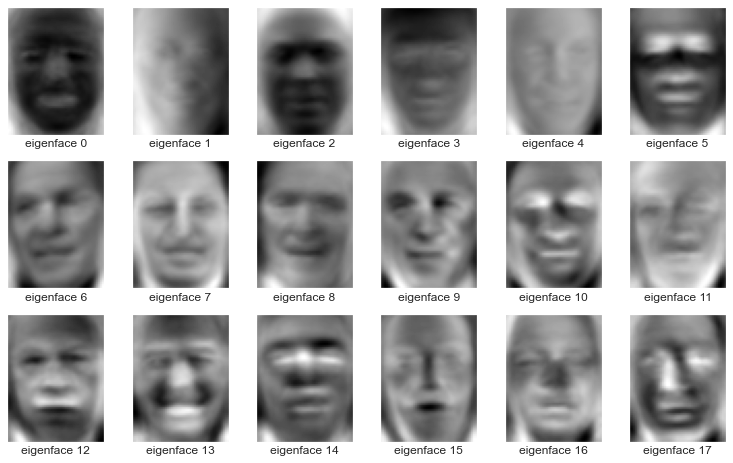

In [11]:
fig, ax = plt.subplots(3, 6, figsize=(13, 8))
for i, a in enumerate(ax.flat):
    a.imshow(eigenfaces[i], cmap='gray')
    a.set(xticks=[], yticks=[], xlabel=f'eigenface {i}')

We use these eigenfaces to train our model. Even though we can hardly distinguish the faces with the naked eye, this is enough for the machine to learn to make accurate predictions. Why? Two reasons. First, this lower-dimensional representation unlocks hidden structures in the data that get lost in the higher-dimensional jungle of features. Second, the less features we use to train our model the faster the computation.

**SVM.** In contrast to Naive Bayes, SVM is not a generative model but a discriminative one. With SVM we don't model each underlying class. Rather, what we model is the separator (or "classifier"), i.e. the boundary that separates the different classes from each other. SVM is a very versitile tool as it allows us to use different kernel transformations. These transformations let us project the data into a higher dimension such that a linear separator is also sufficient. Here we choose the default radial basis function kernel and try it out with different values for the C parameter, which controls the margin hardness, and gamma parameter, which controls the size of the radial basis function.

NB: kernel in this context stands for the similarity relationship between the data points representing the classes.

In [12]:
# SVM classifier
svc = SVC(kernel='rbf', class_weight='balanced')
# Pipeline
model = make_pipeline(pca, svc)

**Train the model via grid search.** In order to ensure we are getting the maximum in terms of modeling in our specific dataset, we want to pick the model parameters that maximize the overall validation score. `scikit-learn`'s `grid_search` module provides a tool we can use for this purpose. First, we define the set of parameters we want to fine-tune. This is similar to deciding what knobs to turn and in what direction to turn them. Then grid search essentially turns all the knobs and tries out all possible combinations for us doing an exhaustive search. As a result, it finds the settings that maximize the validation score in the training set.

In this example we set the following knobs:

* SVM's C parameter: 1, 5, 10, 50
* SVM's gamma parameter: 0.0001, 0.0005, 0.001, 0.005.

In [13]:
# Set varying parameters
param_grid = {'svc__C': [1, 5, 10, 50, 100, 500, 1000, 5000],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
# Build the grid search meta-estimator
grid = GridSearchCV(model, param_grid)
# Fit meta-estimator to the data
grid.fit(X_train, y_train)
# Extract best parameters
print(grid.best_params_)

{'svc__C': 1000, 'svc__gamma': 0.001}


The optimal parameter values are $C = 1000$ and $\gamma = 0.001$. We use these parameters to build our model.

In [14]:
# Build model with best parameters
model = grid.best_estimator_

**Predict.** Now that we have fitted our model to the training set, we use it on the test set to predict labels. We compare our resulting predictions to the previously unseen true labels in the test set. 

In [15]:
# Compute predictions
y_fitted = model.predict(X_test)

**Inspecting the results.** Let's get a visual cue. Let's look at the first few new images we feed to our model and see how well it can tell what new image corresponds to what personality it knows. Wrong predictions are marked in red.

Text(0.5, 0.98, 'Predicted Labels - incorrect labels shown in red')

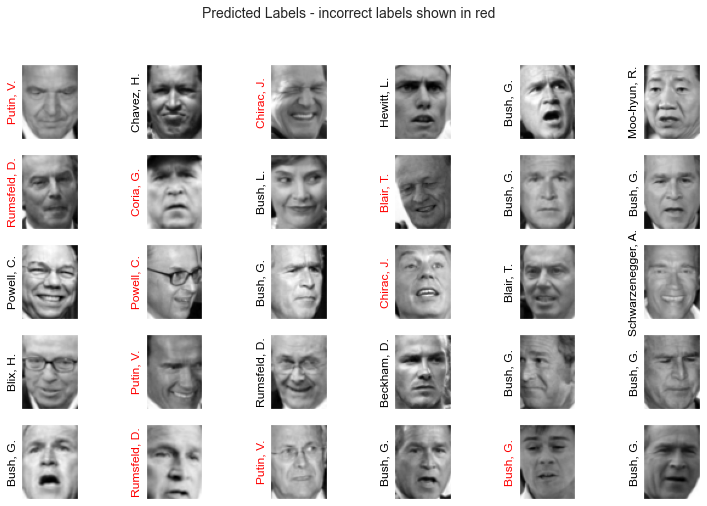

In [16]:
# Display first few results
fig, ax = plt.subplots(5, 6, figsize=(13, 8))
for i, a in enumerate(ax.flat):
    a.imshow(X_test[i].reshape(62, 47), cmap='gray')
    a.set(xticks=[], yticks=[])
    a.set_ylabel(f'{lfw.target_names[y_fitted[i]].split()[-1]}, {lfw.target_names[y_fitted[i]].split()[0][0]}.', 
                 color='black' if y_fitted[i] == y_test[i] else 'red')
fig.suptitle('Predicted Labels - incorrect labels shown in red', size=14)

Though we mainly have hits, we also see some misses. For whatever reason our model seems to see more Putins and Chiracs than we actually have - among others of couse. :)

**Confusion matrix.** For a more serious evaluation of our trained model, let's construct a confusion matrix. The confusion matrix gives us a detailed overview of how much our model confounds the true labels. That way we can easily spot the mismatches.

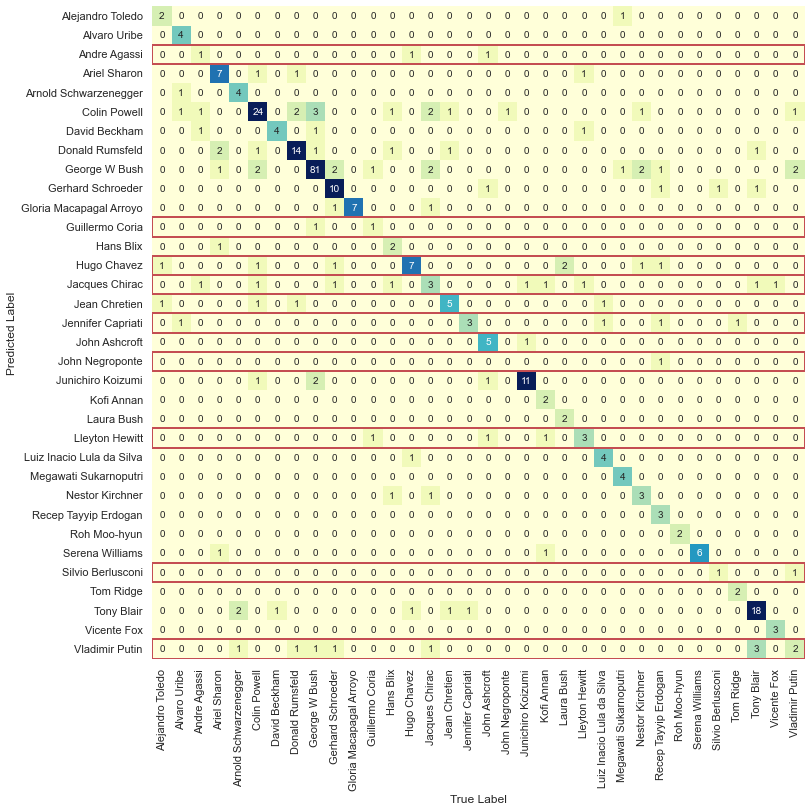

In [20]:
# Compute confusion matrix
cmat = confusion_matrix(y_test, y_fitted)
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cmat.T, square=True, annot=True, fmt='d', cmap='YlGnBu', cbar=False, vmax=10,
            xticklabels=lfw.target_names, yticklabels=lfw.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
prob_rows = (2, 11, 13, 14, 16, 18, 22, 29, 33) 
# Mark problem rows
for i in prob_rows:
    ax.add_patch(patches.Rectangle((0, i), 34, 1, edgecolor='r', fill=False, lw=2))

Besides Mr Putin and Monsieur Chirac as seen in the first few images in the test set, our model seems to have a hard time telling the likes of Agassi or Negroponte apart from other personalities. This might be because we didn't have enough training data for these personalities or because the new images we are showing the model are considerably different than the ones it saw when we trained it.

In spite of not being perfect, our model does seem to do well overall. To confirm this, though, let's compute the precision, recall and accuracy.

In [18]:
print(classification_report(y_test, y_fitted, target_names=lfw.target_names))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.67      0.50      0.57         4
             Alvaro Uribe       1.00      0.57      0.73         7
             Andre Agassi       0.33      0.25      0.29         4
             Ariel Sharon       0.70      0.58      0.64        12
    Arnold Schwarzenegger       0.80      0.57      0.67         7
             Colin Powell       0.63      0.75      0.69        32
            David Beckham       0.57      0.80      0.67         5
          Donald Rumsfeld       0.67      0.74      0.70        19
            George W Bush       0.85      0.90      0.88        90
        Gerhard Schroeder       0.71      0.62      0.67        16
  Gloria Macapagal Arroyo       0.78      1.00      0.88         7
          Guillermo Coria       0.50      0.33      0.40         3
                Hans Blix       0.67      0.33      0.44         6
              Hugo Chavez       0.50      0.70      0.58     

In [19]:
accuracy_score(y_test, y_fitted)

0.702247191011236

**Outcome.** We do see that our "problem cases" have a low precision. Overall, our model correctly tells around 70% of the new images we present it with. This is considerably better than blind guessing, which has a probability of ~29.4% or 1/34.

**Epilogue: Increasing accuracy.** We could further increase accuracy by adding more data either by being more strict on the minimum number of images we want per personality, say 50 instead of 30, or by making the training set bigger. Both come at a cost, though. We either lose (too many) personalities or we end up with too few pictures to test our model.